Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the MNIST training and test datasets using
   ``torchvision``
2. Define a neural network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing MNIST
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load MNIST.



import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
60,000 training samples and 10,000 test samples


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

2. Define a Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Three hidden layers, input size = height * width of the image,
output size = the number of classes (which is 10 in the case of MNIST)



Use the base class: nn.Module

The nn.Module mainly takes care of storing the paramters of the neural network.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        
        # flatten image
        x = x[:, 0, ...].view(-1, 28*28)
        
        # feed layer 1
        out_layer1 = self.fc1(x)
        out_layer1 = F.relu(out_layer1)
        
        # feed layer 2
        out_layer2 = self.fc2(out_layer1)
        out_layer2 = F.relu(out_layer2)
        
        # feed layer 3
        out_layer3 = self.fc3(out_layer2)
        
        return out_layer3


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 99 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.000
[1,   100] loss: 0.109
[1,   199] loss: 0.132
[1,   298] loss: 0.149
[1,   397] loss: 0.159
[1,   496] loss: 0.145
[1,   595] loss: 0.102
[1,   694] loss: 0.113
[1,   793] loss: 0.163
[1,   892] loss: 0.147
[1,   991] loss: 0.101
[1,  1090] loss: 0.069
[1,  1189] loss: 0.205
[1,  1288] loss: 0.128
[1,  1387] loss: 0.085
[1,  1486] loss: 0.082
[1,  1585] loss: 0.100
[1,  1684] loss: 0.149
[1,  1783] loss: 0.131
[1,  1882] loss: 0.161
[1,  1981] loss: 0.118
[1,  2080] loss: 0.147
[1,  2179] loss: 0.127
[1,  2278] loss: 0.120
[1,  2377] loss: 0.085
[1,  2476] loss: 0.053
[1,  2575] loss: 0.141
[1,  2674] loss: 0.115
[1,  2773] loss: 0.117
[1,  2872] loss: 0.113
[1,  2971] loss: 0.086
[1,  3070] loss: 0.132
[1,  3169] loss: 0.138
[1,  3268] loss: 0.120
[1,  3367] loss: 0.150
[1,  3466] loss: 0.127
[1,  3565] loss: 0.186
[1,  3664] loss: 0.083
[1,  3763] loss: 0.085
[1,  3862] loss: 0.106
[1,  3961] loss: 0.096
[1,  4060] loss: 0.120
[1,  4159] loss: 0.130
[1,  4258] 

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [7]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)



Performance on the test dataset.



In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


# Plot images: 


tensor([4, 0, 1, 3])
    4     0     1     3


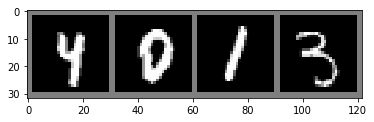

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
predictions = net(images)

_, predicted = torch.max(predictions.data, 1)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % predicted[j].item() for j in range(4)))